<div style="display: flex; background-color: #3F579F;">
    <h1 style="margin: auto; font-weight: bold; padding: 30px 30px 0px 30px; color:#fff;" align="center">Implement a scoring model - P7</h1>
</div>
<div style="display: flex; background-color: #3F579F; margin: auto; padding: 5px 30px 0px 30px;" >
    <h3 style="width: 100%; text-align: center; float: left; font-size: 24px; color:#fff;" align="center">| Modeling Notebook |</h3>
</div>
<div style="display: flex; background-color: #3F579F; margin: auto; padding: 10px 30px 30px 30px;">
    <h4 style="width: 100%; text-align: center; float: left; font-size: 24px; color:#fff;" align="center">Data Scientist course - OpenClassrooms</h4>
</div>

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">1. Libraries</h2>
</div>

In [2]:
## General
import timeit
import re
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.style as style

## Scikit Learn library
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import (train_test_split, StratifiedKFold, 
                                     HalvingGridSearchCV, cross_validate)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import (precision_score, roc_auc_score, recall_score, 
                             f1_score, fbeta_score, confusion_matrix, roc_curve, 
                             PrecisionRecallDisplay, ConfusionMatrixDisplay,
                            precision_recall_curve)
from sklearn.feature_selection import SelectKBest, f_classif

## imbalanced-learn
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.over_sampling import SMOTE

## LightGBM
from lightgbm import LGBMClassifier

## To use S3 files
import boto3
from sagemaker import get_execution_role

## SHapley Additive exPlanations.
import shap

## Lightweight pipelining in Python
import joblib

## Own specific functions 
from functions import *

%matplotlib inline

In [3]:
# load JS visualization code to notebook
shap.initjs()

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">2. Importing files</h2>
</div>

<div class="alert alert-block alert-info">
    <p>Definning S3 parameters
   </p>
</div>

In [4]:
connexion = boto3.client('s3')

In [5]:
bucket = "oc-data-scientist"
subfolder = "oc-p7/datasets/finals_datasets"
data_key = "df_current_clients.csv"
data_key_client_to_predict = "df_clients_to_predict.csv"

In [6]:
role = get_execution_role()
conn = boto3.client('s3')

In [7]:
contents = conn.list_objects(Bucket=bucket, Prefix=subfolder)['Contents']
for f in contents:
    print(f['Key'])

oc-p7/datasets/finals_datasets/
oc-p7/datasets/finals_datasets/df_clients_to_predict.csv
oc-p7/datasets/finals_datasets/df_clients_to_predict_feature_selected.csv
oc-p7/datasets/finals_datasets/df_current_clients.csv
oc-p7/datasets/finals_datasets/df_current_clients_feature_selected.csv


In [8]:
data_location = "s3://{}/{}/{}".format(bucket, subfolder, data_key)

In [9]:
data_location_client_to_predict = "s3://{}/{}/{}".format(bucket, subfolder, data_key_client_to_predict)

<div class="alert alert-block alert-info">
    <p>Let's load the current clients
   </p>
</div>

In [10]:
df_current_clients = pd.read_csv(data_location)

In [11]:
df_analysis(df_current_clients, "df_current_clients", analysis_type="header")


Analysis Header of df_current_clients dataset
--------------------------------------------------------------------------------
- Dataset shape:			 307507 rows and 509 columns
- Total of NaN values:			 0
- Percentage of NaN:			 0.0 %
- Total of infinite values:		 0
- Percentage of infinite values:	 0.0 %
- Total of full duplicates rows:	 0
- Total of empty rows:			 0
- Total of empty columns:		 0
- Unique indexes:			 True
- Memory usage:				 1.2 GB


In [12]:
df_clients_to_predict = pd.read_csv(data_location_client_to_predict)

In [13]:
df_analysis(df_clients_to_predict, "df_clients_to_predict", analysis_type="header")


Analysis Header of df_clients_to_predict dataset
--------------------------------------------------------------------------------
- Dataset shape:			 48744 rows and 508 columns
- Total of NaN values:			 0
- Percentage of NaN:			 0.0 %
- Total of infinite values:		 0
- Percentage of infinite values:	 0.0 %
- Total of full duplicates rows:	 0
- Total of empty rows:			 0
- Total of empty columns:		 0
- Unique indexes:			 True
- Memory usage:				 188.9 MB


<div class="alert alert-block alert-warning">
    <p><b>Observations / Conclusions</b></p>
    <p>First of all, let's treat the memory to optimize its usage.</p>
</div>

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">3. Optimizing memory usage</h2>
</div>

<div class="alert alert-block alert-warning">
    <p>We should optimize the memory usage to avoid problems during executions</p>
</div>

In [14]:
df_current_clients = memory_optimization(df_current_clients)

In [15]:
df_analysis(df_current_clients, "df_clients_to_predict", analysis_type="header")


Analysis Header of df_clients_to_predict dataset
--------------------------------------------------------------------------------
- Dataset shape:			 307507 rows and 509 columns
- Total of NaN values:			 0
- Percentage of NaN:			 0.0 %
- Total of infinite values:		 0
- Percentage of infinite values:	 0.0 %
- Total of full duplicates rows:	 0
- Total of empty rows:			 0
- Total of empty columns:		 0
- Unique indexes:			 True
- Memory usage:				 459.8 MB


In [16]:
df_clients_to_predict = memory_optimization(df_clients_to_predict)

In [17]:
df_analysis(df_clients_to_predict, "df_clients_to_predict", analysis_type="header")


Analysis Header of df_clients_to_predict dataset
--------------------------------------------------------------------------------
- Dataset shape:			 48744 rows and 508 columns
- Total of NaN values:			 0
- Percentage of NaN:			 0.0 %
- Total of infinite values:		 0
- Percentage of infinite values:	 0.0 %
- Total of full duplicates rows:	 0
- Total of empty rows:			 0
- Total of empty columns:		 0
- Unique indexes:			 True
- Memory usage:				 76.9 MB


<div class="alert alert-block alert-success">
    <p><b>Observations / Conclusions</b></p>
    <p>The memory usage has been reduced.</p>
</div>

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">4. Analyzing target variable</h2>
</div>

<div class="alert alert-block alert-info">
    <p>We are going to analyze the target variable to see whether is an imbalanced class
   </p>
</div>

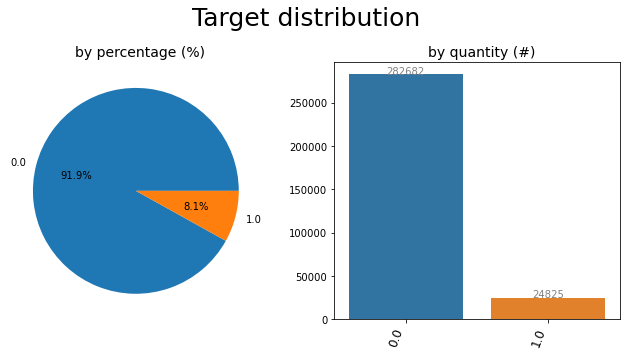

In [18]:
barplot_and_pie(df_current_clients["TARGET"], "Target distribution", " ")

<div class="alert alert-block alert-warning">
    <p><b>Observations / Conclusions</b></p>
    <ul style="list-style-type: square;">
        <li>Here we can see how much the dataset is imbalanced so, we are facing a imbalanced classification problem</li>
        <li>It is easily identifying that there are <b>loans that were repaid (0)</b> in comparison of <b>loans that were not repaid (1)</b>s</li>
        <li>We are going to treat the imbalanced class into a pipeline during the modeling</li>
    </ul> 
</div>

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">5. Splitting data</h2>
</div>

<div class="alert alert-block alert-info">
    <p>First of all, let's identify the training columns in the dataset
   </p>
</div>

In [19]:
NOT_TRAINING_COLUMNS  = ["TARGET", "SK_ID_CURR", "SK_ID_BUREAU", "SK_ID_PREV", "index"] 
TRAINING_COLUMNS = [col for col in df_current_clients.columns if col not in NOT_TRAINING_COLUMNS]

<div class="alert alert-block alert-info">
    <p>Let's split the all data
   </p>
</div>

In [20]:
X = df_current_clients[TRAINING_COLUMNS]

In [21]:
y_target = df_current_clients.loc[:,"TARGET"]

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y_target, test_size=0.20, stratify=y_target, random_state=42)

In [23]:
print("X_train: {}".format(X_train.shape))
print("y_train: {}".format(y_train.shape))
print("---------------------")
print("X_test: {}".format(X_test.shape))
print("y_test: {}".format(y_test.shape))

X_train: (246005, 506)
y_train: (246005,)
---------------------
X_test: (61502, 506)
y_test: (61502,)


<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">6. Modelisation initial</h2>
</div>

<div class="alert alert-block alert-success">
    <p>We are going to face an <b>Unbalanced Classification Problem</b> and we are going to use three models</p>
    <ul style="list-style-type: square;">
        <li>Random Forest Classifier</li>
        <li>LightGBM</li>
        <li>Gradient Boosting</li>
    </ul>
    <p>Also, we are going to use a Dummy Classifier and baseline to compare the models</p>
</div>

<div style="background-color: #506AB9;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">6.1. General parameters</h3>
</div>

<div class="alert alert-block alert-info">
    <p>We are going to use Stratified K-Folds cross-validator to ensure that each fold of dataset has the same proportion of observations with a given label.</p>
</div>

In [24]:
stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

<div class="alert alert-block alert-info">
    <p>Metrics to use.</p>
</div>

In [25]:
scoring = ["roc_auc", "recall", "f1"]

<div style="background-color: #506AB9;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">6.2. Baselines</h3>
</div>

<div class="alert alert-block alert-info">
    <p>List of models to use. Dummy Classifier and Base line of the models</p>
</div>

In [26]:
classifiers = {
    "Dummy Classifier" : DummyClassifier(),
    "Baseline - Random Forest" : RandomForestClassifier(),
    "Baseline - LightGBM" : LGBMClassifier(),
    "Baseline - Gradient Boosting" : GradientBoostingClassifier()
}

In [27]:
# List of metrics results for each models 
LIST_MODEL, LIST_RECALL, LIST_ROC_AUC, LIST_F1, LIST_DURATION  = ([] for i in range(5))

for key, clf in classifiers.items():
    
    start_time_model = timeit.default_timer()
    
    scores = cross_validate(clf, X_train, y_train, 
                            cv=stratified_kfold, scoring=scoring)
    
    end_time_model =  round(timeit.default_timer() - start_time_model, 3)
    
    # Adding results into LIST
    LIST_MODEL.append(key)
    LIST_RECALL.append(round(scores.get("test_recall").mean(), 3))
    LIST_ROC_AUC.append(round(scores.get("test_roc_auc").mean(), 3))
    LIST_F1.append(round(scores.get("test_f1").mean(), 3))
    LIST_DURATION.append(end_time_model)

<div class="alert alert-block alert-info">
    <p>Dataframe to compare metrics.</p>
</div>

In [28]:
df_models_metrics = pd.DataFrame({
    "Model" : LIST_MODEL,
    "ROC-AUC" : LIST_ROC_AUC,
    "Recall" : LIST_RECALL,    
    "F1" : LIST_F1,
    "Duration" : LIST_DURATION,
})

<div class="alert alert-block alert-info">
    <p>Let's transform the duration to minutes.</p>
</div>

In [29]:
df_models_metrics["Duration"] = round(df_models_metrics["Duration"]/60, 1)

In [30]:
df_models_metrics

,Model,ROC-AUC,Recall,F1,Duration
0,Dummy Classifier,0.500,0.000,0.000,0.0
1,Baseline - Random Forest,0.715,0.001,0.002,8.3
2,Baseline - LightGBM,0.773,0.033,0.062,0.3
3,Baseline - Gradient Boosting,0.765,0.019,0.036,27.9


<div class="alert alert-block alert-success">
    <p><b>Observations / Conclusions</b></p>
    <p>it is easy to see how much time the ensembles models. Due to that, we do not consider to plot the duration</p>
</div>

In [31]:
COLUMNS = ["Model", "Recall", "ROC-AUC", "F1"]

In [32]:
df_models_metrics_reduced = pd.melt(df_models_metrics[COLUMNS], id_vars="Model", var_name="Metric", value_name="Value")
df_models_metrics_reduced.head()

,Model,Metric,Value
0,Dummy Classifier,Recall,0.000
1,Baseline - Random Forest,Recall,0.001
2,Baseline - LightGBM,Recall,0.033
3,Baseline - Gradient Boosting,Recall,0.019
4,Dummy Classifier,ROC-AUC,0.500


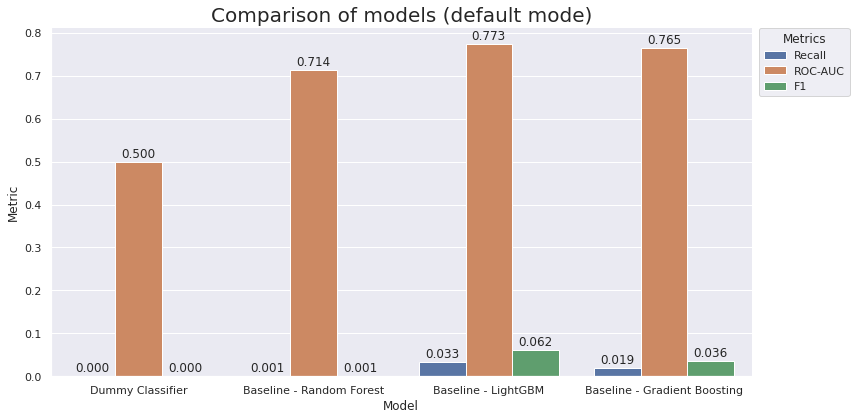

In [228]:
fig, ax1 = plt.subplots(figsize=(12, 6))
plot = sns.barplot(x="Model", y="Value", hue="Metric", data=df_models_metrics_reduced, ax=ax1)
for p in plot.patches:
    plot.annotate(format(p.get_height(), ".3f"), (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha="center", va="center", xytext=(0, 8), textcoords="offset points")
plt.title("Comparison of models (default mode)", size=20)
plt.legend(bbox_to_anchor=(1.14, 1), borderaxespad=0, title="Metrics")
plt.tight_layout()
plt.xlabel("Model", size=12)
plt.ylabel("Metric", size=12)
sns.despine(fig)

<div class="alert alert-block alert-success">
    <p><b>Observations / Conclusions</b></p>
    <p>LightGBM and Gradient Boosting got the best result based on ROC-AUC but, we have to consider the execution time that is not in the plot</p>
</div>

<div style="background-color: #506AB9;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">6.3. Hyperparameters Tuning</h3>
</div>

<div class="alert alert-block alert-info">
    <p>For reasons of processing cost, we are going to tune the models with a subsample of the data.<br>Done this, we will proceed to continue the modeling with the parameters obtained.</p>
</div>

<div style="background-color: #506AB9;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">6.3.1. Subsample of the data</h4>
</div>

<div class="alert alert-block alert-info">
    <p>Now, we are going to do a subsamble of the dataset to tune some parameters before the modeling
   </p>
</div>

In [33]:
df_subsample = df_current_clients.copy()

In [34]:
df_subsample = df_subsample.sample(frac=0.5)

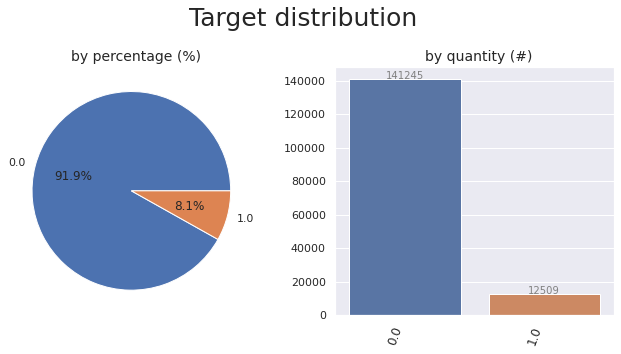

In [25]:
barplot_and_pie(df_subsample["TARGET"], "Target distribution", " ")

<div class="alert alert-block alert-info">
    <p>Now, we are going to split the subsample of the data to tune the models
   </p>
</div>

In [35]:
X_ss = df_subsample[TRAINING_COLUMNS]

In [36]:
y_target_ss = df_subsample.loc[:,"TARGET"]

In [37]:
X_train_ss, X_test_ss, y_train_ss, y_test_ss = train_test_split(X_ss, y_target_ss, test_size=0.20, stratify=y_target_ss, random_state=42)

In [38]:
print("X_train_ss: {}".format(X_train_ss.shape))
print("y_train_ss: {}".format(y_train_ss.shape))
print("---------------------")
print("X_test_ss: {}".format(X_test_ss.shape))
print("y_test_ss: {}".format(y_test_ss.shape))

X_train_ss: (123003, 506)
y_train_ss: (123003,)
---------------------
X_test_ss: (30751, 506)
y_test_ss: (30751,)


<div style="background-color: #506AB9;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">6.3.2. Random Forest</h4>
</div>

<div class="alert alert-block alert-info">
    <p>Let's try to tune the Random Forest model</p>
    <p>Parameters settings</p>
</div>

In [43]:
param_grid = {
    "n_estimators" : np.arange(500, 1000, 100),
    "max_depth" : np.arange(20, 30, 2),
}

<div class="alert alert-block alert-info">
    <p>Executing the model</p>
</div>

In [44]:
clf_rf = RandomForestClassifier(random_state=42)

In [45]:
search_rf = HalvingGridSearchCV(clf_rf, param_grid, scoring="roc_auc", cv=stratified_kfold, n_jobs=-1)

In [46]:
search_rf.fit(X_train_ss, y_train_ss)

HalvingGridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                    estimator=RandomForestClassifier(random_state=42),
                    n_jobs=-1,
                    param_grid={'max_depth': array([20, 22, 24, 26, 28]),
                                'n_estimators': array([500, 600, 700, 800, 900])})

<div class="alert alert-block alert-info">
    <p>ROC-AUC score</p>
</div>

In [47]:
search_rf.best_score_

0.9192214824028683

<div class="alert alert-block alert-info">
    <p>The best parameters</p>
</div>

In [48]:
search_rf.best_params_

{'max_depth': 26, 'n_estimators': 500}

In [39]:
rf_parameters = search_rf.best_params_

<div style="background-color: #506AB9;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">6.3.3. LightGBM</h4>
</div>

<div class="alert alert-block alert-info">
    <p>Let's try to tune the Random LightGBM</p>
    <p>Parameters settings</p>
</div>

In [29]:
param_grid = {
    "n_estimators" : [8000, 10000],
    "num_leaves" : [32, 34], 
    "max_depth" : [8, 9]
}

<div class="alert alert-block alert-info">
    <p>Executing the model</p>
</div>

In [30]:
clf_lgbm = LGBMClassifier(random_state=42)

In [31]:
search_lgbm = HalvingGridSearchCV(clf_lgbm, param_grid, scoring="roc_auc", cv=stratified_kfold, n_jobs=-1)

In [32]:
search_lgbm.fit(X_train_ss, y_train_ss)

HalvingGridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                    estimator=LGBMClassifier(random_state=42), n_jobs=-1,
                    param_grid={'max_depth': [8, 9],
                                'n_estimators': [8000, 10000],
                                'num_leaves': [32, 34]},
                    scoring='roc_auc')

<div class="alert alert-block alert-info">
    <p>ROC-AUC score</p>
</div>

In [33]:
search_lgbm.best_score_

0.7396840027850832

<div class="alert alert-block alert-info">
    <p>The best parameters</p>
</div>

In [34]:
search_lgbm.best_params_

{'max_depth': 9, 'n_estimators': 8000, 'num_leaves': 32}

In [40]:
lgbm_parameters = search_lgbm.best_params_

<div style="background-color: #506AB9;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">6.3.4. Gradient Boosting</h4>
</div>

<div class="alert alert-block alert-info">
    <p>Let's try to tune the Random LightGBM</p>
    <p>Parameters settings</p>
</div>

In [35]:
param_grid = {
    "n_estimators" : np.arange(500, 1000, 100),
    "max_depth" : np.arange(20, 30, 2),
}

<div class="alert alert-block alert-info">
    <p>Executing the model.<br>In this case, we are going to add some parameters to reduce the execution time</p>
</div>

In [36]:
clf_gb = GradientBoostingClassifier(validation_fraction=0.2, 
                                    n_iter_no_change=5,
                                    tol=0.01,
                                    random_state=42)

In [37]:
search_gb = HalvingGridSearchCV(clf_gb, param_grid, scoring="roc_auc", cv=stratified_kfold, n_jobs=-1)

In [38]:
search_gb.fit(X_train_ss, y_train_ss)

HalvingGridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                    estimator=GradientBoostingClassifier(n_iter_no_change=5,
                                                         random_state=42,
                                                         tol=0.01,
                                                         validation_fraction=0.2),
                    n_jobs=-1,
                    param_grid={'max_depth': array([20, 22, 24, 26, 28]),
                                'n_estimators': array([500, 600, 700, 800, 900])},
                    scoring='roc_auc')

<div class="alert alert-block alert-info">
    <p>ROC-AUC score</p>
</div>

In [39]:
search_gb.best_score_

0.6568425917657963

<div class="alert alert-block alert-info">
    <p>The best parameters</p>
</div>

In [40]:
search_gb.best_params_

{'max_depth': 20, 'n_estimators': 700}

In [41]:
gb_parameters = search_gb.best_params_

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">7. Custom evaluations</h2>
</div>

<div style="background-color: #506AB9;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">7.1. Threshold selection</h3>
</div>

<div class="alert alert-block alert-info">
    <p>Based on the predictions, we are going to identify the best treshold to mesure our models.
    </p>
</div>

In [42]:
def threshold_selection(y_train, y_prob):
    """
    Method used to calculate the threshold.

    Parameters:
    -----------------
        df (pandas.DataFrame): Dataset to analyze
        y_train (1d array-like): True values
        y_prob (1d array-like): Probabilite values predicted
        
    Returns:
    -----------------
        threshold (float) : Best threshold value
        Threshold (image) : Plot the threshold and the best score
    """
    
    thresholds = np.arange(0, 1, 0.001)
    scores = []
    
    for threshold in thresholds:
        y_pred = (y_prob >= threshold).astype("int")
        score = f1_score(y_test, y_pred)
        scores.append(score)
        
    scores = np.asarray(scores)
    ix = np.argmax(scores)
    
    best_threshold, best_score = (thresholds[ix], round(scores[ix], 3))
    
    print("Best results")
    print("- Best Threshold:\t", best_threshold)
    print("- Best Score:\t\t", best_score)
    print("\n")
    
    plt.subplots(1, figsize=(6, 5))
    plt.plot(thresholds, scores, lw=1)
    plt.axvline(best_threshold, ls="--", lw=1, c="r")
    plt.title("Threshold")
    plt.xlabel("proba threshold")
    plt.ylabel("Score performed")
    plt.show()
    
    return best_threshold

<div style="background-color: #506AB9;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">7.2. Custom Score</h3>
</div>

<div class="alert alert-block alert-info">
    <p>We need to penalize the <b>False Negative</b> that are loands <b>will be in default</b>, and they were <b>predicted incorrectly</b>.<br>Due to that, we are going to define a <b>Custom Score</b>.
    </p>
</div>

In [43]:
def custom_score(y_true, y_pred, threshold):
    """
    Method used to calculate a score based on the penalization of False Negatives.

    Parameters:
    -----------------
        y_true (series): True values
        y_pred (series): Predicted values
        threshold (float): Threshold value to use
        
    Returns:
    -----------------
        Score. (float): Score obtained based on the rules defined to measure. 
    """
    
    # Getting the probability outputs from "predict_proba"
    y_pred = (y_pred > threshold).astype(int)
    
    TN_rate = 1        # Loans that are not in default and were predicted correctly
    TP_rate = 1        # Loans that are in default and were predicted correctly
    FP_rate = 0        # Loans that are not in default and were predicted incorrectly
    FN_rate = -100      # Loans that are in default and were were predicted incorrectly
    
    # Getting all values based on confusion matrix
    (TN, FP, FN, TP) = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()

    # Total of default and not default cases
    total_not_default = TN + FP     # Not default cases
    total_default = TP + FN         # Default cases 
    
    gain_total = TN*TN_rate + TP*TP_rate + FP*FP_rate + FN*FN_rate
    gain_maximun = total_not_default*TN_rate + total_default*TP_rate
    gain_minumun = total_not_default*TN_rate + total_default*FN_rate
    
    # normalize to get score between 0 (baseline) and 1
    score = (gain_total - gain_minumun) / (gain_maximun - gain_minumun)
    
    return score

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">8. Modelisation using class_weight</h2>
</div>

<div class="alert alert-block alert-info">
    <p>At this point, we are going to use the parameter <b>class_weight</b> to affect the computation of the model to penalize differently a false classification from the minority and majority class </p>
</div>

<div style="background-color: #506AB9;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">8.1. Random Forest</h3>
</div>

<div class="alert alert-block alert-info">
    <p>Let's execute the model considering the parameters obtained</p>
</div>

In [44]:
clf_rf_cw = RandomForestClassifier(**rf_parameters,
                                   class_weight="balanced",
                                   random_state=42,
                                   n_jobs=-1)

<div class="alert alert-block alert-info">
    <p>Executing the model with the complete dataset</p>
</div>

In [45]:
start_time_model = timeit.default_timer()

clf_rf_cw.fit(X_train, y_train)

end_time_model =  round(timeit.default_timer() - start_time_model, 3)

<div class="alert alert-block alert-info">
    <p>Predict the probabilities</p>
</div>

In [46]:
y_prob = clf_rf_cw.predict_proba(X_test)
y_prob = y_prob[:, 1]

<div class="alert alert-block alert-info">
    <p>Let's selet the threshold based on the best parameters</p>
</div>

Best results
- Best Threshold:	 0.194
- Best Score:		 0.292




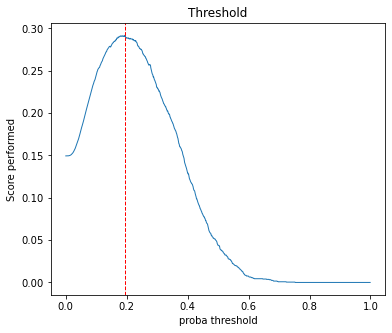

In [47]:
threshold = threshold_selection(y_test, y_prob)

<div class="alert alert-block alert-info">
    <p>Making the predictions based on the probabilities and threshold</p>
</div>

In [48]:
y_pred = (y_prob >= threshold).astype(int)

<div class="alert alert-block alert-info">
    <p>Now, we can get the metrics</p>
</div>

In [49]:
roc_auc = round(roc_auc_score(y_test, y_prob), 3)
recall_0, recall_1 = recall_score(y_test, y_pred, average=None).round(3)
f1 = round(f1_score(y_test, y_pred), 3)
precision = round(precision_score(y_test, y_pred), 3)
custom = round(custom_score(y_test, y_pred, threshold), 3)

<div class="alert alert-block alert-info">
    <p>Plotting the Confusion Matrix</p>
</div>

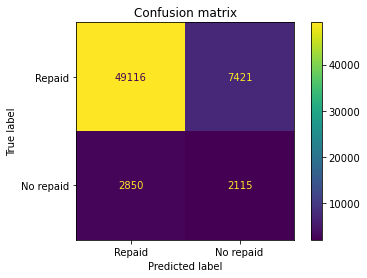

In [50]:
display = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=["Repaid", "No repaid"])
_ = display.ax_.set_title("Confusion matrix")

<div class="alert alert-block alert-info">
    <p>Plotting the Compute ROC curve and ROC area for each class</p>
</div>

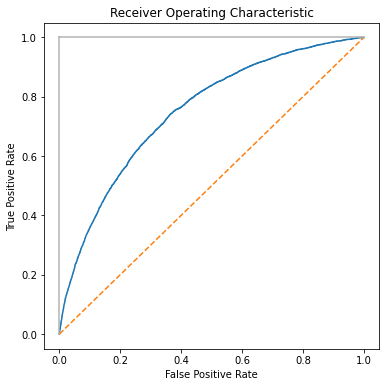

In [51]:
fpr = dict()
tpr = dict()
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_prob.ravel())

plt.subplots(1, figsize=(6, 6))
plt.title("Receiver Operating Characteristic")
plt.plot(fpr["micro"], tpr["micro"])
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

<div class="alert alert-block alert-info">
    <p>Plotting the Precision-Recall curve</p>
</div>

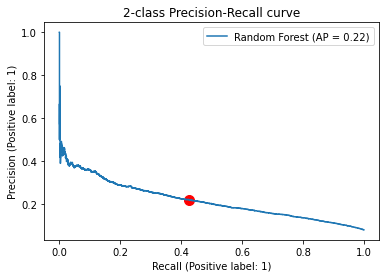

In [52]:
precision_, recall_, thresh_ = precision_recall_curve(y_test, y_prob)

plt.subplots(1, figsize=(6, 4))
plt.plot(recall_, precision_,  color="#1F77B4");
plt.scatter(recall_1, precision, marker="o", s=100, color="red", label="Best")
plt.xlabel("Recall (Positive label: 1)")
plt.ylabel("Precision (Positive label: 1)")
plt.title("2-class Precision-Recall curve")
plt.legend(["Random Forest (AP = %.2f)"% (precision)], loc=0)
plt.show()

<div class="alert alert-block alert-info">
    <p>Let's save the metrics to compare against the others models</p>
</div>

In [53]:
df_models_metrics_complete = pd.DataFrame({
    "Model" : ["Class weight - Random Forest"],
    "ROC-AUC" : roc_auc,    
    "Recall - 0" : recall_0,
    "Recall - 1" : recall_1,
    "Precision" : precision,
    "F1" : f1,    
    "Custom Score" : custom,
    "Duration" : round(end_time_model/60, 1)
})

In [54]:
df_models_metrics_complete

,Model,ROC-AUC,Recall - 0,Recall - 1,Precision,F1,Custom Score,Duration
0,Class weight - Random Forest,0.75,0.869,0.426,0.222,0.292,0.411,1.5


<div style="background-color: #506AB9;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">8.2. LightGBM</h3>
</div>

<div class="alert alert-block alert-info">
    <p>Let's execute the model considering the parameters obtained</p>
    <p>In this case, we are also going to consider the parameters used on the Kernel's Kaggle selected</p>
</div>

In [55]:
clf_lgbm_cw = LGBMClassifier(**lgbm_parameters, class_weight="balanced", learning_rate=0.02,
                             colsample_bytree=0.9497036, subsample=0.8715623,
                             reg_alpha=0.041545473, reg_lambda=0.0735294,
                             min_split_gain=0.0222415, min_child_weight=39.3259775,
                             random_state=42, n_jobs=-1)

<div class="alert alert-block alert-info">
    <p>Executing the model with the complete dataset</p>
</div>

In [56]:
start_time_model = timeit.default_timer()

clf_lgbm_cw.fit(X_train, y_train)

end_time_model =  round(timeit.default_timer() - start_time_model, 3)

<div class="alert alert-block alert-info">
    <p>Predict the probabilities</p>
</div>

In [57]:
y_prob = clf_lgbm_cw.predict_proba(X_test)
y_prob = y_prob[:, 1]

<div class="alert alert-block alert-info">
    <p>Let's selet the threshold based on the best parameters</p>
</div>

Best results
- Best Threshold:	 0.535
- Best Score:		 0.327




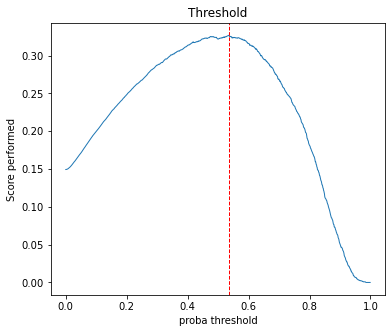

In [58]:
threshold = threshold_selection(y_test, y_prob)

<div class="alert alert-block alert-info">
    <p>Making the predictions based on the probabilities and threshold</p>
</div>

In [59]:
y_pred = (y_prob >= threshold).astype(int)

<div class="alert alert-block alert-info">
    <p>Now, we can get the metrics</p>
</div>

In [60]:
roc_auc = round(roc_auc_score(y_test, y_prob), 3)
recall_0, recall_1 = recall_score(y_test, y_pred, average=None).round(3)
f1 = round(f1_score(y_test, y_pred), 3)
precision = round(precision_score(y_test, y_pred), 3)
custom = round(custom_score(y_test, y_pred, threshold), 3)

<div class="alert alert-block alert-info">
    <p>Plotting the Confusion Matrix</p>
</div>

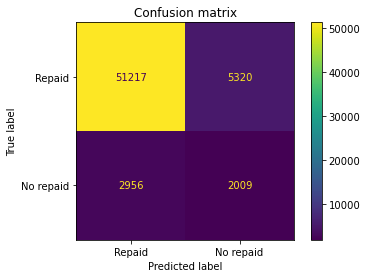

In [61]:
display = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=["Repaid", "No repaid"])
_ = display.ax_.set_title("Confusion matrix")

<div class="alert alert-block alert-info">
    <p>Plotting the Compute ROC curve and ROC area for each class</p>
</div>

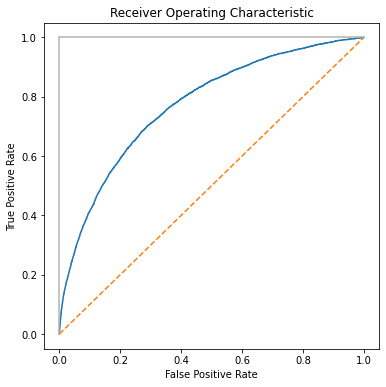

In [62]:
fpr = dict()
tpr = dict()
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_prob.ravel())

plt.subplots(1, figsize=(6, 6))
plt.title("Receiver Operating Characteristic")
plt.plot(fpr["micro"], tpr["micro"])
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

<div class="alert alert-block alert-info">
    <p>Plotting the Precision-Recall curve</p>
</div>

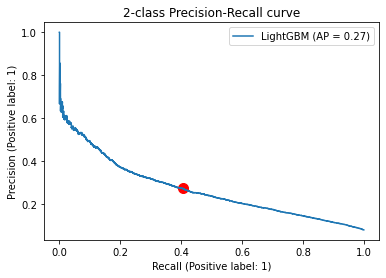

In [63]:
precision_, recall_, thresh_ = precision_recall_curve(y_test, y_prob)

plt.subplots(1, figsize=(6, 4))
plt.plot(recall_, precision_,  color="#1F77B4");
plt.scatter(recall_1, precision, marker="o", s=100, color="red", label="Best")
plt.xlabel("Recall (Positive label: 1)")
plt.ylabel("Precision (Positive label: 1)")
plt.title("2-class Precision-Recall curve")
plt.legend(["LightGBM (AP = %.2f)"% (precision)], loc=0)
plt.show()

<div class="alert alert-block alert-info">
    <p>Let's save the metrics to compare against the others models</p>
</div>

In [64]:
df_temp = pd.DataFrame({
    "Model" : ["Class weight - LightGBM"],
    "ROC-AUC" : roc_auc,    
    "Recall - 0" : recall_0,
    "Recall - 1" : recall_1,
    "Precision" : precision,
    "F1" : f1,    
    "Custom Score" : custom,
    "Duration" : round(end_time_model/60, 1)
})

In [65]:
df_models_metrics_complete = pd.concat([df_models_metrics_complete, df_temp])
df_models_metrics_complete.reset_index(drop=True)

,Model,ROC-AUC,Recall - 0,Recall - 1,Precision,F1,Custom Score,Duration
0,Class weight - Random Forest,0.750,0.869,0.426,0.222,0.292,0.411,1.5
1,Class weight - LightGBM,0.772,0.906,0.405,0.274,0.327,0.394,3.0


<div style="background-color: #506AB9;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">8.3. Gradient Boosting</h3>
</div>

<div class="alert alert-block alert-info">
    <p>Unfortunately, Gradient Boosting (GBM) doesn't have a parameters call <b>class_weight</b> to treat with Imbalanced Class.</p>
    <p>But, GBM deals with class imbalance by constructing successive training sets based on incorrectly classified examples</p>
</div>

In [66]:
clf_gb_cw = GradientBoostingClassifier(**gb_parameters, 
                                       validation_fraction=0.2, 
                                       n_iter_no_change=5,
                                       tol=0.01, random_state=42)

<div class="alert alert-block alert-info">
    <p>Executing the model with the complete dataset</p>
</div>

In [67]:
start_time_model = timeit.default_timer()

clf_gb_cw.fit(X_train, y_train)

end_time_model =  round(timeit.default_timer() - start_time_model, 3)

<div class="alert alert-block alert-info">
    <p>Predict the probabilities</p>
</div>

In [68]:
y_prob = clf_gb_cw.predict_proba(X_test)
y_prob = y_prob[:, 1]

<div class="alert alert-block alert-info">
    <p>Let's selet the threshold based on the best parameters</p>
</div>

Best results
- Best Threshold:	 0.073
- Best Score:		 0.222




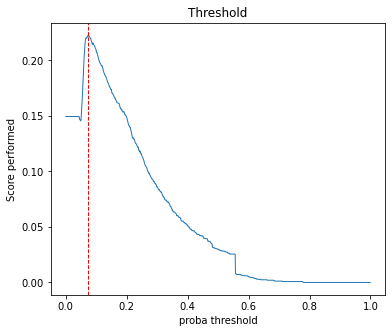

In [69]:
threshold = threshold_selection(y_test, y_prob)

<div class="alert alert-block alert-info">
    <p>Making the predictions based on the probabilities and threshold</p>
</div>

In [70]:
y_pred = (y_prob >= threshold).astype(int)

<div class="alert alert-block alert-info">
    <p>Now, we can get the metrics</p>
</div>

In [71]:
roc_auc = round(roc_auc_score(y_test, y_prob), 3)
recall_0, recall_1 = recall_score(y_test, y_pred, average=None).round(3)
f1 = round(f1_score(y_test, y_pred), 3)
precision = round(precision_score(y_test, y_pred), 3)
custom = round(custom_score(y_test, y_pred, threshold), 3)

<div class="alert alert-block alert-info">
    <p>Plotting the Confusion Matrix</p>
</div>

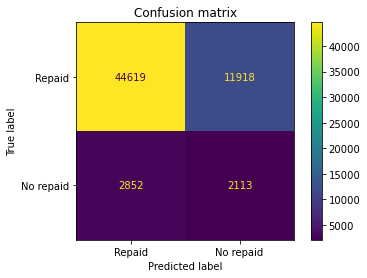

In [72]:
display = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=["Repaid", "No repaid"])
_ = display.ax_.set_title("Confusion matrix")

<div class="alert alert-block alert-info">
    <p>Plotting the Compute ROC curve and ROC area for each class</p>
</div>

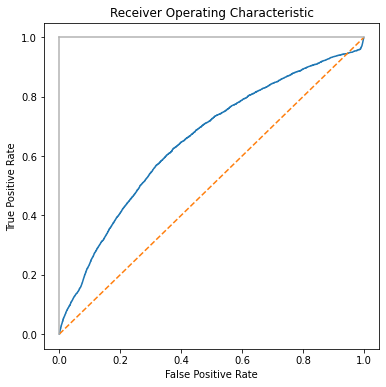

In [73]:
fpr = dict()
tpr = dict()
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_prob.ravel())

plt.subplots(1, figsize=(6, 6))
plt.title("Receiver Operating Characteristic")
plt.plot(fpr["micro"], tpr["micro"])
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

<div class="alert alert-block alert-info">
    <p>Plotting the Precision-Recall curve</p>
</div>

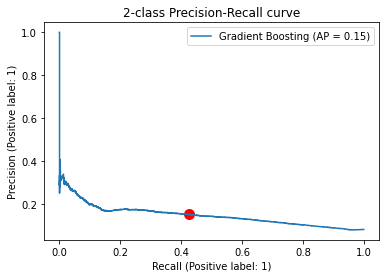

In [74]:
precision_, recall_, thresh_ = precision_recall_curve(y_test, y_prob)

plt.subplots(1, figsize=(6, 4))
plt.plot(recall_, precision_,  color="#1F77B4");
plt.scatter(recall_1, precision, marker="o", s=100, color="red", label="Best")
plt.xlabel("Recall (Positive label: 1)")
plt.ylabel("Precision (Positive label: 1)")
plt.title("2-class Precision-Recall curve")
plt.legend(["Gradient Boosting (AP = %.2f)"% (precision)], loc=0)
plt.show()

<div class="alert alert-block alert-info">
    <p>Let's save the metrics to compare against the others models</p>
</div>

In [75]:
df_temp = pd.DataFrame({
    "Model" : ["Tuned - Gradient Boosting"],
    "ROC-AUC" : roc_auc,    
    "Recall - 0" : recall_0,
    "Recall - 1" : recall_1,
    "Precision" : precision,
    "F1" : f1,    
    "Custom Score" : custom,
    "Duration" : round(end_time_model/60, 1)
})

In [76]:
df_models_metrics_complete = pd.concat([df_models_metrics_complete, df_temp])
df_models_metrics_complete.reset_index(drop=True)

,Model,ROC-AUC,Recall - 0,Recall - 1,Precision,F1,Custom Score,Duration
0,Class weight - Random Forest,0.750,0.869,0.426,0.222,0.292,0.411,1.5
1,Class weight - LightGBM,0.772,0.906,0.405,0.274,0.327,0.394,3.0
2,Tuned - Gradient Boosting,0.653,0.789,0.426,0.151,0.222,0.402,4.7


<div class="alert alert-block alert-success">
    <p><b>Observations / Conclusions</b></p>
    <ul style="list-style-type: square;">
        <li><b>Class weight - Random Forest</b> and <b>Class weight - LightGBM</b> have improved their scores</li>
        <li><b>Tuned - Gradient Boosting</b> doesn't have a parameter Class weight to treat with Imbalanced Class. It treats Imbalanced Class internally</li>
    </ul>    
</div>

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">9. Modelisation using OverSampling</h2>
</div>

<div class="alert alert-block alert-info">
    <p>To treat the unbalanced class, we are going to implement OverSampling technique with SMOTE.</p>
</div>

In [77]:
smote = SMOTE(random_state=42, n_jobs=-1)

<div style="background-color: #506AB9;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">9.1. Random Forest</h3>
</div>

<div class="alert alert-block alert-info">
    <p>Let's define the pipeline to put inside it the defined SMOTE</p>
</div>

In [78]:
clf_rf_os = imbpipeline(steps = [["Smote", smote],
                                 ["Random_Forest", RandomForestClassifier(**rf_parameters,
                                                                          random_state=42,
                                                                          n_jobs=-1)]
                                 ]
                        )

<div class="alert alert-block alert-info">
    <p>Executing the model after making the OverSampling</p>
</div>

In [79]:
start_time_model = timeit.default_timer()

clf_rf_os.fit(X_train, y_train)

end_time_model =  round(timeit.default_timer() - start_time_model, 3)

<div class="alert alert-block alert-info">
    <p>Predict the probabilities</p>
</div>

In [80]:
y_prob = clf_rf_os.predict_proba(X_test)
y_prob = y_prob[:, 1]

<div class="alert alert-block alert-info">
    <p>Let's selet the threshold based on the best parameters</p>
</div>

Best results
- Best Threshold:	 0.243
- Best Score:		 0.266




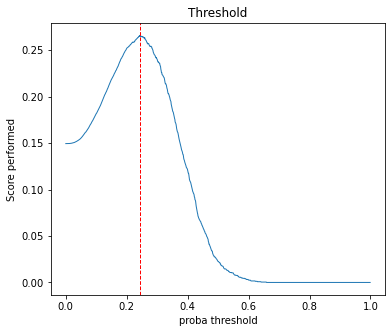

In [81]:
threshold = threshold_selection(y_test, y_prob)

<div class="alert alert-block alert-info">
    <p>Making the predictions based on the probabilities and threshold</p>
</div>

In [82]:
y_pred = (y_prob >= threshold).astype(int)

<div class="alert alert-block alert-info">
    <p>Now, we can get the metrics</p>
</div>

In [83]:
roc_auc = round(roc_auc_score(y_test, y_prob), 3)
recall_0, recall_1 = recall_score(y_test, y_pred, average=None).round(3)
f1 = round(f1_score(y_test, y_pred), 3)
precision = round(precision_score(y_test, y_pred), 3)
custom = round(custom_score(y_test, y_pred, threshold), 3)

<div class="alert alert-block alert-info">
    <p>Plotting the Confusion Matrix</p>
</div>

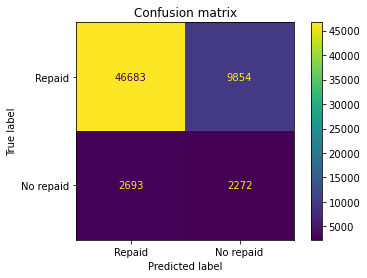

In [84]:
display = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=["Repaid", "No repaid"])
_ = display.ax_.set_title("Confusion matrix")

<div class="alert alert-block alert-info">
    <p>Plotting the Compute ROC curve and ROC area for each class</p>
</div>

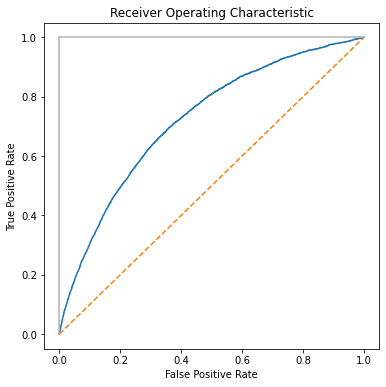

In [85]:
fpr = dict()
tpr = dict()
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_prob.ravel())

plt.subplots(1, figsize=(6, 6))
plt.title("Receiver Operating Characteristic")
plt.plot(fpr["micro"], tpr["micro"])
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

<div class="alert alert-block alert-info">
    <p>Plotting the Precision-Recall curve</p>
</div>

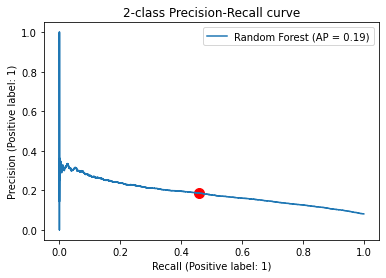

In [86]:
precision_, recall_, thresh_ = precision_recall_curve(y_test, y_prob)

plt.subplots(1, figsize=(6, 4))
plt.plot(recall_, precision_,  color="#1F77B4");
plt.scatter(recall_1, precision, marker="o", s=100, color="red", label="Best")
plt.xlabel("Recall (Positive label: 1)")
plt.ylabel("Precision (Positive label: 1)")
plt.title("2-class Precision-Recall curve")
plt.legend(["Random Forest (AP = %.2f)"% (precision)], loc=0)
plt.show()

<div class="alert alert-block alert-info">
    <p>Let's save the metrics to compare against the others models</p>
</div>

In [87]:
df_temp = pd.DataFrame({
    "Model" : ["OverSampling - Random Forest"],
    "ROC-AUC" : roc_auc,    
    "Recall - 0" : recall_0,
    "Recall - 1" : recall_1,
    "Precision" : precision,
    "F1" : f1,    
    "Custom Score" : custom,
    "Duration" : round(end_time_model/60, 1)
})

In [88]:
df_models_metrics_complete = pd.concat([df_models_metrics_complete, df_temp])
df_models_metrics_complete.reset_index(drop=True)

,Model,ROC-AUC,Recall - 0,Recall - 1,Precision,F1,Custom Score,Duration
0,Class weight - Random Forest,0.750,0.869,0.426,0.222,0.292,0.411,1.5
1,Class weight - LightGBM,0.772,0.906,0.405,0.274,0.327,0.394,3.0
2,Tuned - Gradient Boosting,0.653,0.789,0.426,0.151,0.222,0.402,4.7
3,OverSampling - Random Forest,0.721,0.826,0.458,0.187,0.266,0.438,4.6


<div style="background-color: #506AB9;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">9.2. LightGBM</h3>
</div>

<div class="alert alert-block alert-info">
    <p>Let's define the pipeline to put inside it the defined SMOTE</p>
</div>

In [274]:
clf_lgbm_os = imbpipeline(steps = [["Smote", smote],
                                   ["LightGBM", LGBMClassifier(**lgbm_parameters, learning_rate=0.02,
                                                                    colsample_bytree=0.9497036, subsample=0.8715623,
                                                                    reg_alpha=0.041545473, reg_lambda=0.0735294,
                                                                    min_split_gain=0.0222415, min_child_weight=39.3259775,
                                                                    random_state=42, n_jobs=-1)]
                                   ]
                          )

<div class="alert alert-block alert-info">
    <p>Executing the model after making the OverSampling</p>
</div>

In [275]:
start_time_model = timeit.default_timer()

clf_lgbm_os.fit(X_train, y_train)

end_time_model =  round(timeit.default_timer() - start_time_model, 3)

<div class="alert alert-block alert-info">
    <p>Predict the probabilities</p>
</div>

In [91]:
y_prob = clf_lgbm_os.predict_proba(X_test)
y_prob = y_prob[:, 1]

<div class="alert alert-block alert-info">
    <p>Let's selet the threshold based on the best parameters</p>
</div>

Best results
- Best Threshold:	 0.13
- Best Score:		 0.322




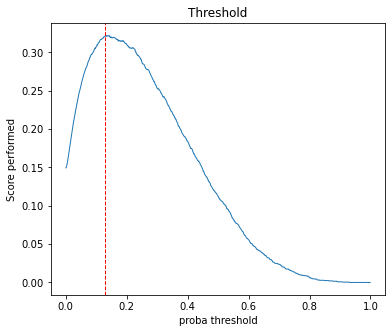

In [92]:
threshold = threshold_selection(y_test, y_prob)

<div class="alert alert-block alert-info">
    <p>Making the predictions based on the probabilities and threshold</p>
</div>

In [93]:
y_pred = (y_prob >= threshold).astype(int)

<div class="alert alert-block alert-info">
    <p>Now, we can get the metrics</p>
</div>

In [94]:
roc_auc = round(roc_auc_score(y_test, y_prob), 3)
recall_0, recall_1 = recall_score(y_test, y_pred, average=None).round(3)
f1 = round(f1_score(y_test, y_pred), 3)
precision = round(precision_score(y_test, y_pred), 3)
custom = round(custom_score(y_test, y_pred, threshold), 3)

<div class="alert alert-block alert-info">
    <p>Plotting the Confusion Matrix</p>
</div>

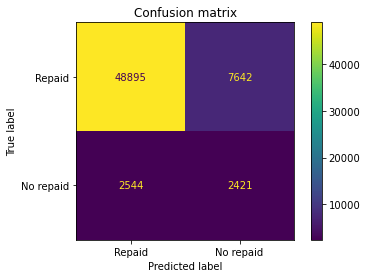

In [95]:
display = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=["Repaid", "No repaid"])
_ = display.ax_.set_title("Confusion matrix")

<div class="alert alert-block alert-info">
    <p>Plotting the Compute ROC curve and ROC area for each class</p>
</div>

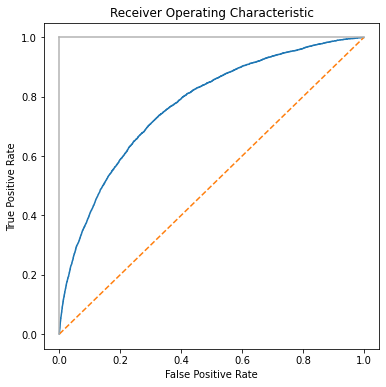

In [96]:
fpr = dict()
tpr = dict()
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_prob.ravel())

plt.subplots(1, figsize=(6, 6))
plt.title("Receiver Operating Characteristic")
plt.plot(fpr["micro"], tpr["micro"])
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

<div class="alert alert-block alert-info">
    <p>Plotting the Precision-Recall curve</p>
</div>

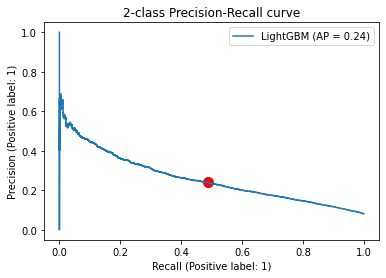

In [97]:
precision_, recall_, thresh_ = precision_recall_curve(y_test, y_prob)

plt.subplots(1, figsize=(6, 4))
plt.plot(recall_, precision_,  color="#1F77B4");
plt.scatter(recall_1, precision, marker="o", s=100, color="red", label="Best")
plt.xlabel("Recall (Positive label: 1)")
plt.ylabel("Precision (Positive label: 1)")
plt.title("2-class Precision-Recall curve")
plt.legend(["LightGBM (AP = %.2f)"% (precision)], loc=0)
plt.show()

<div class="alert alert-block alert-info">
    <p>Let's save the metrics to compare against the others models</p>
</div>

In [98]:
df_temp = pd.DataFrame({
    "Model" : ["OverSampling - LightGBM"],
    "ROC-AUC" : roc_auc,    
    "Recall - 0" : recall_0,
    "Recall - 1" : recall_1,
    "Precision" : precision,
    "F1" : f1,    
    "Custom Score" : custom,
    "Duration" : round(end_time_model/60, 1)
})

In [101]:
df_models_metrics_complete = pd.concat([df_models_metrics_complete, df_temp])
df_models_metrics_complete.reset_index(drop=True)

,Model,ROC-AUC,Recall - 0,Recall - 1,Precision,F1,Custom Score,Duration
0,Class weight - Random Forest,0.750,0.869,0.426,0.222,0.292,0.411,1.5
1,Class weight - LightGBM,0.772,0.906,0.405,0.274,0.327,0.394,3.0
2,Tuned - Gradient Boosting,0.653,0.789,0.426,0.151,0.222,0.402,4.7
3,OverSampling - Random Forest,0.721,0.826,0.458,0.187,0.266,0.438,4.6
4,OverSampling - LightGBM,0.771,0.865,0.488,0.241,0.322,0.472,6.3


<div style="background-color: #506AB9;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">9.3. Gradient Boosting</h3>
</div>

<div class="alert alert-block alert-info">
    <p>Let's define the pipeline to put inside it the defined SMOTE</p>
</div>

In [103]:
clf_gb_os = imbpipeline(steps = [["Smote", smote],
                                 ["Gradient Boosting", GradientBoostingClassifier(**gb_parameters,
                                                                                  validation_fraction=0.2, 
                                                                                  n_iter_no_change=5,
                                                                                  tol=0.01, random_state=42)]
                                ]
                       )

<div class="alert alert-block alert-info">
    <p>Executing the model after making the OverSampling</p>
</div>

In [104]:
start_time_model = timeit.default_timer()

clf_gb_os.fit(X_train, y_train)

end_time_model =  round(timeit.default_timer() - start_time_model, 3)

<div class="alert alert-block alert-info">
    <p>Predict the probabilities</p>
</div>

In [105]:
y_prob = clf_gb_os.predict_proba(X_test)
y_prob = y_prob[:, 1]

<div class="alert alert-block alert-info">
    <p>Let's selet the threshold based on the best parameters</p>
</div>

Best results
- Best Threshold:	 0.07200000000000001
- Best Score:		 0.246




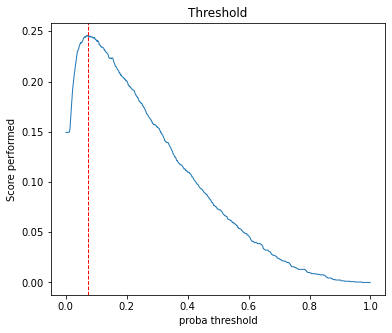

In [106]:
threshold = threshold_selection(y_test, y_prob)

<div class="alert alert-block alert-info">
    <p>Making the predictions based on the probabilities and threshold</p>
</div>

In [107]:
y_pred = (y_prob >= threshold).astype(int)

<div class="alert alert-block alert-info">
    <p>Now, we can get the metrics</p>
</div>

In [108]:
roc_auc = round(roc_auc_score(y_test, y_prob), 3)
recall_0, recall_1 = recall_score(y_test, y_pred, average=None).round(3)
f1 = round(f1_score(y_test, y_pred), 3)
precision = round(precision_score(y_test, y_pred), 3)
custom = round(custom_score(y_test, y_pred, threshold), 3)

<div class="alert alert-block alert-info">
    <p>Plotting the Confusion Matrix</p>
</div>

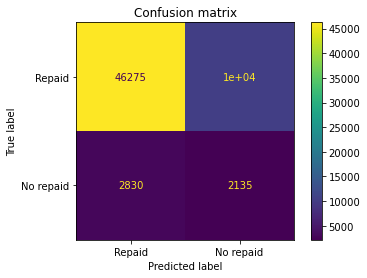

In [109]:
display = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=["Repaid", "No repaid"])
_ = display.ax_.set_title("Confusion matrix")

<div class="alert alert-block alert-info">
    <p>Plotting the Compute ROC curve and ROC area for each class</p>
</div>

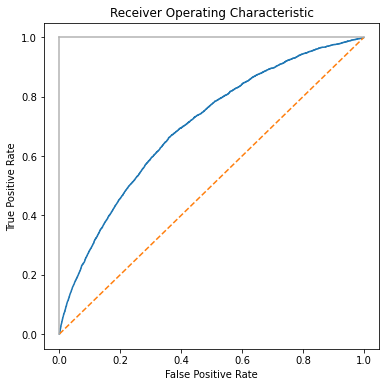

In [110]:
fpr = dict()
tpr = dict()
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_prob.ravel())

plt.subplots(1, figsize=(6, 6))
plt.title("Receiver Operating Characteristic")
plt.plot(fpr["micro"], tpr["micro"])
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

<div class="alert alert-block alert-info">
    <p>Plotting the Precision-Recall curve</p>
</div>

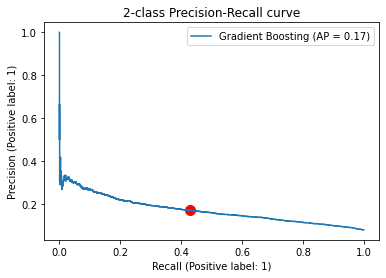

In [111]:
precision_, recall_, thresh_ = precision_recall_curve(y_test, y_prob)

plt.subplots(1, figsize=(6, 4))
plt.plot(recall_, precision_,  color="#1F77B4")
plt.scatter(recall_1, precision, marker="o", s=100, color="red", label="Best")
plt.xlabel("Recall (Positive label: 1)")
plt.ylabel("Precision (Positive label: 1)")
plt.title("2-class Precision-Recall curve")
plt.legend(["Gradient Boosting (AP = %.2f)"% (precision)], loc=0)
plt.show()

<div class="alert alert-block alert-info">
    <p>Let's save the metrics to compare against the others models</p>
</div>

In [112]:
df_temp = pd.DataFrame({
    "Model" : ["OverSampling - Gradient Boosting"],
    "ROC-AUC" : roc_auc,    
    "Recall - 0" : recall_0,
    "Recall - 1" : recall_1,
    "Precision" : precision,
    "F1" : f1,    
    "Custom Score" : custom,
    "Duration" : round(end_time_model/60, 1)
})

In [113]:
df_models_metrics_complete = pd.concat([df_models_metrics_complete, df_temp])
df_models_metrics_complete.reset_index(drop=True)

,Model,ROC-AUC,Recall - 0,Recall - 1,Precision,F1,Custom Score,Duration
0,Class weight - Random Forest,0.750,0.869,0.426,0.222,0.292,0.411,1.5
1,Class weight - LightGBM,0.772,0.906,0.405,0.274,0.327,0.394,3.0
2,Tuned - Gradient Boosting,0.653,0.789,0.426,0.151,0.222,0.402,4.7
3,OverSampling - Random Forest,0.721,0.826,0.458,0.187,0.266,0.438,4.6
4,OverSampling - LightGBM,0.771,0.865,0.488,0.241,0.322,0.472,6.3
5,OverSampling - Gradient Boosting,0.700,0.818,0.430,0.172,0.246,0.410,75.0


<div class="alert alert-block alert-success">
    <p><b>Observations / Conclusions</b></p>
    <ul style="list-style-type: square;">
        <li>All models have improved the Recall - 1</li>
        <li>OverSampling - Gradient Boosting has taken a lot of time</li>
    </ul>    
</div>

<div class="alert alert-block alert-info">
    <p>Let's plot all metrics</p>
</div>

In [114]:
df_temp = df_models_metrics_complete.drop(["Recall - 0", "Duration"], axis=1)

In [115]:
df_temp = pd.melt(df_temp, id_vars="Model", var_name="Metric", value_name="Value")
df_temp.head()

,Model,Metric,Value
0,Class weight - Random Forest,ROC-AUC,0.750
1,Class weight - LightGBM,ROC-AUC,0.772
2,Tuned - Gradient Boosting,ROC-AUC,0.653
3,OverSampling - Random Forest,ROC-AUC,0.721
4,OverSampling - LightGBM,ROC-AUC,0.771


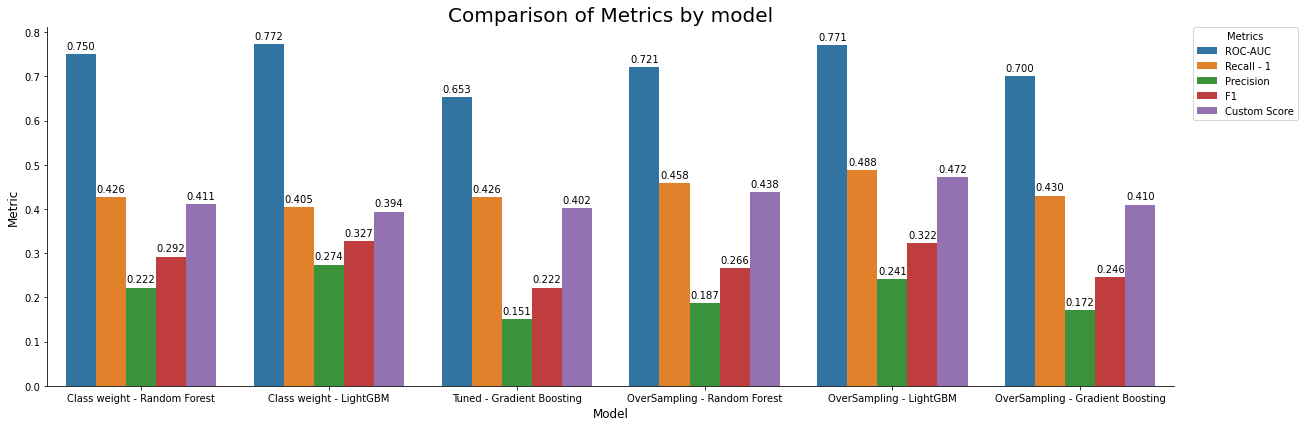

In [116]:
fig, ax1 = plt.subplots(figsize=(18, 6))
plot = sns.barplot(x="Model", y="Value", hue="Metric", data=df_temp, ax=ax1)
for p in plot.patches:
    plot.annotate(format(p.get_height(), ".3f"), (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha="center", va="center", xytext=(0, 8), textcoords="offset points")
plt.title("Comparison of Metrics by model", size=20)
plt.legend(bbox_to_anchor=(1.11, 1), borderaxespad=0, title="Metrics")
plt.tight_layout()
plt.xlabel("Model", size=12)
plt.ylabel("Metric", size=12)
sns.despine(fig)

<div class="alert alert-block alert-success">
    <p><b>Observations / Conclusions</b></p>
    <ul style="list-style-type: square;">
        <li>The results are very similar without time comparison</li>
        <li>We can notice a small lift in the OverSampling - Gradient Boosting results in comparison with Tuned - Gradiend Boosting</li>
        <li>Recall - 1 in OverSampling - LightGBM is a little higher in comparison with the others</li>
    </ul>    
</div>

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">10. Feature selection</h2>
</div>

<div class="alert alert-block alert-info">
    <p>Now, we are going to apply a Feature Selection on OverSampling - LightGBM. To do that we are going to use one of the more popular methods</p>
    <ul style="list-style-type: square;">
        <li>Select the top k variables: SelectKBest</li>
    </ul>
</div>

In [117]:
df_best_model = df_models_metrics_complete[df_models_metrics_complete["Model"]=="OverSampling - LightGBM"]
df_best_model

,Model,ROC-AUC,Recall - 0,Recall - 1,Precision,F1,Custom Score,Duration
0,OverSampling - LightGBM,0.771,0.865,0.488,0.241,0.322,0.472,6.3


<div class="alert alert-block alert-info">
    <p>First of all, we are going to identify how many features we can keep</p>
</div>

In [345]:
fs = SelectKBest(score_func=f_classif)

In [346]:
fs.fit(X_train, y_train)

Features [223 228 244 278 286 289 315 320 325 335 348 377 383 387 396 408 414 478] are constant.
invalid value encountered in true_divide


SelectKBest()

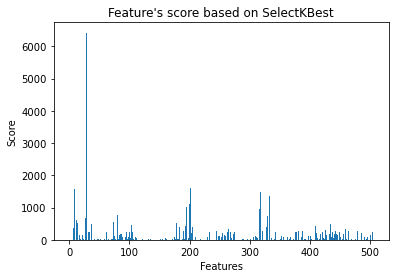

In [347]:
plt.bar([i for i in range(len(fs.scores_))], fs.scores_,)
plt.title("Feature's score based on SelectKBest")
plt.ylabel("Score")
plt.xlabel("Features")
plt.show()

<div class="alert alert-block alert-success">
    <p><b>Observations / Conclusions</b></p>
    <p>Based on the Score's plot, we can decide only to keep 150 features.</p>
</div>

In [348]:
fs = SelectKBest(score_func=f_classif, k=150)

In [349]:
fs.fit(X_train, y_train)

Features [223 228 244 278 286 289 315 320 325 335 348 377 383 387 396 408 414 478] are constant.
invalid value encountered in true_divide


SelectKBest(k=150)

In [350]:
X_train_fs = fs.transform(X_train)
X_test_fs = fs.transform(X_test)

In [351]:
print("X_train:\t {}".format(X_train.shape))
print("X_train_fs:\t {}".format(X_train_fs.shape))
print("----------------------------------")
print("X_test:\t\t {}".format(X_test.shape))
print("X_test_fs:\t {}".format(X_test_fs.shape))

X_train:	 (246005, 506)
X_train_fs:	 (246005, 150)
----------------------------------
X_test:		 (61502, 506)
X_test_fs:	 (61502, 150)


<div class="alert alert-block alert-info">
    <p>Now, let's test the best model</p>
    <p>Executing the model with the <b>new dataset</b></p>
</div>

In [352]:
start_time_model = timeit.default_timer()

clf_lgbm_os.fit(X_train_fs, y_train)

end_time_model =  round(timeit.default_timer() - start_time_model, 3)

<div class="alert alert-block alert-info">
    <p>Predict the probabilities</p>
</div>

In [353]:
y_prob = clf_lgbm_os.predict_proba(X_test_fs)
y_prob = y_prob[:, 1]

<div class="alert alert-block alert-info">
    <p>Let's selet the threshold based on the best parameters</p>
</div>

Best results
- Best Threshold:	 0.135
- Best Score:		 0.313




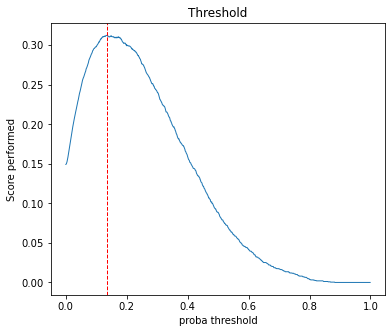

In [354]:
threshold = threshold_selection(y_test, y_prob)

<div class="alert alert-block alert-info">
    <p>Making the predictions based on the probabilities and threshold</p>
</div>

In [355]:
y_pred = (y_prob >= threshold).astype(int)

<div class="alert alert-block alert-info">
    <p>Now, we can get the metrics</p>
</div>

In [356]:
roc_auc = round(roc_auc_score(y_test, y_prob), 3)
recall_0, recall_1 = recall_score(y_test, y_pred, average=None).round(3)
f1 = round(f1_score(y_test, y_pred), 3)
precision = round(precision_score(y_test, y_pred), 3)
custom = round(custom_score(y_test, y_pred, threshold), 3)

<div class="alert alert-block alert-info">
    <p>Plotting the Confusion Matrix</p>
</div>

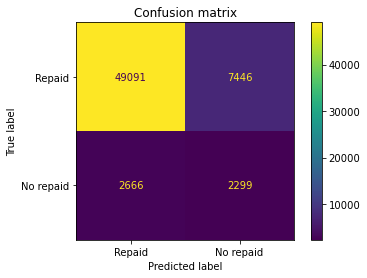

In [357]:
display = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=["Repaid", "No repaid"])
_ = display.ax_.set_title("Confusion matrix")

<div class="alert alert-block alert-info">
    <p>Plotting the Compute ROC curve and ROC area for each class</p>
</div>

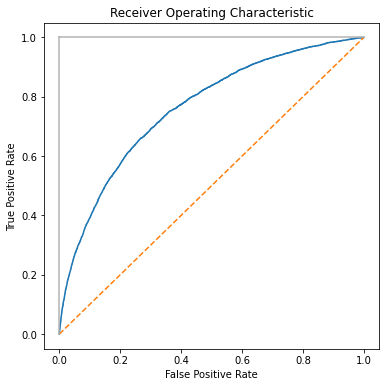

In [358]:
fpr = dict()
tpr = dict()
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_prob.ravel())

plt.subplots(1, figsize=(6, 6))
plt.title("Receiver Operating Characteristic")
plt.plot(fpr["micro"], tpr["micro"])
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

<div class="alert alert-block alert-info">
    <p>Plotting the Precision-Recall curve</p>
</div>

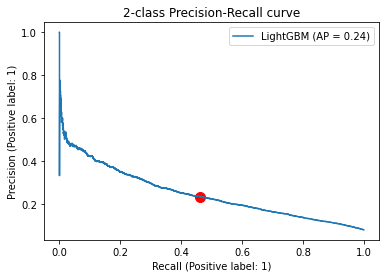

In [359]:
precision_, recall_, thresh_ = precision_recall_curve(y_test, y_prob)

plt.subplots(1, figsize=(6, 4))
plt.plot(recall_, precision_,  color="#1F77B4");
plt.scatter(recall_1, precision, marker="o", s=100, color="red", label="Best")
plt.xlabel("Recall (Positive label: 1)")
plt.ylabel("Precision (Positive label: 1)")
plt.title("2-class Precision-Recall curve")
plt.legend(["LightGBM (AP = %.2f)"% (precision)], loc=0)
plt.show()

<div class="alert alert-block alert-info">
    <p>Let's save the metrics to compare against the others models</p>
</div>

In [360]:
df_temp = pd.DataFrame({
    "Model" : ["OverSampling / SelectKBest - LightGBM"],
    "ROC-AUC" : roc_auc,    
    "Recall - 0" : recall_0,
    "Recall - 1" : recall_1,
    "Precision" : precision,
    "F1" : f1,    
    "Custom Score" : custom,
    "Duration" : round(end_time_model/60, 1)
})

In [368]:
df_best_model = pd.concat([df_best_model, df_temp])
df_best_model.reset_index(drop=True)

,Model,ROC-AUC,Recall - 0,Recall - 1,Precision,F1,Custom Score,Duration
0,OverSampling - LightGBM,0.771,0.865,0.488,0.241,0.322,0.472,6.3
1,OverSampling / SelectKBest - LightGBM,0.761,0.868,0.463,0.236,0.313,0.448,3.7


<div class="alert alert-block alert-info">
    <p>Let's plot all metrics</p>
</div>

In [369]:
df_temp = pd.melt(df_best_model, id_vars="Model", var_name="Metric", value_name="Value")
df_temp.head()

,Model,Metric,Value
0,OverSampling - LightGBM,ROC-AUC,0.771
1,OverSampling / SelectKBest - LightGBM,ROC-AUC,0.761
2,OverSampling - LightGBM,Recall - 0,0.865
3,OverSampling / SelectKBest - LightGBM,Recall - 0,0.868
4,OverSampling - LightGBM,Recall - 1,0.488


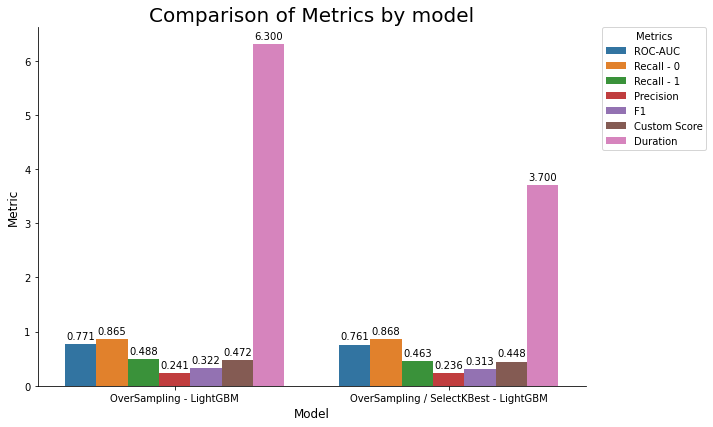

In [370]:
fig, ax1 = plt.subplots(figsize=(10, 6))
plot = sns.barplot(x="Model", y="Value", hue="Metric", data=df_temp, ax=ax1)
for p in plot.patches:
    plot.annotate(format(p.get_height(), ".3f"), (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha="center", va="center", xytext=(0, 8), textcoords="offset points")
plt.title("Comparison of Metrics by model", size=20)
plt.legend(bbox_to_anchor=(1.22, 1), borderaxespad=0, title="Metrics")
plt.tight_layout()
plt.xlabel("Model", size=12)
plt.ylabel("Metric", size=12)
sns.despine(fig)

<div class="alert alert-block alert-success">
    <p><b>Observations / Conclusions</b></p>
    <p>The results are very similar, but the execution time is half.</p>
</div>

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">11. Model interpretation</h2>
</div>

<div class="alert alert-block alert-info">
    <p>Now, we are going to interpret the model based on the <b>Class weight / SelectKBest - LightGBM</b> model </p>
    <p>But first, we have to identify the features selected</p>
</div>

In [373]:
cols = fs.get_support(indices=True)

In [374]:
X_k_best_features = X.iloc[:, cols]

In [375]:
df_analysis(X_k_best_features, "X_k_best_features", analysis_type="header")


Analysis Header of X_k_best_features dataset
--------------------------------------------------------------------------------
- Dataset shape:			 307507 rows and 150 columns
- Total of NaN values:			 0
- Percentage of NaN:			 0.0 %
- Total of infinite values:		 0
- Percentage of infinite values:	 0.0 %
- Total of full duplicates rows:	 0
- Total of empty rows:			 0
- Total of empty columns:		 0
- Unique indexes:			 True
- Memory usage:				 151.9 MB


<div style="background-color: #506AB9;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">11.1. Global interpretation</h3>
</div>

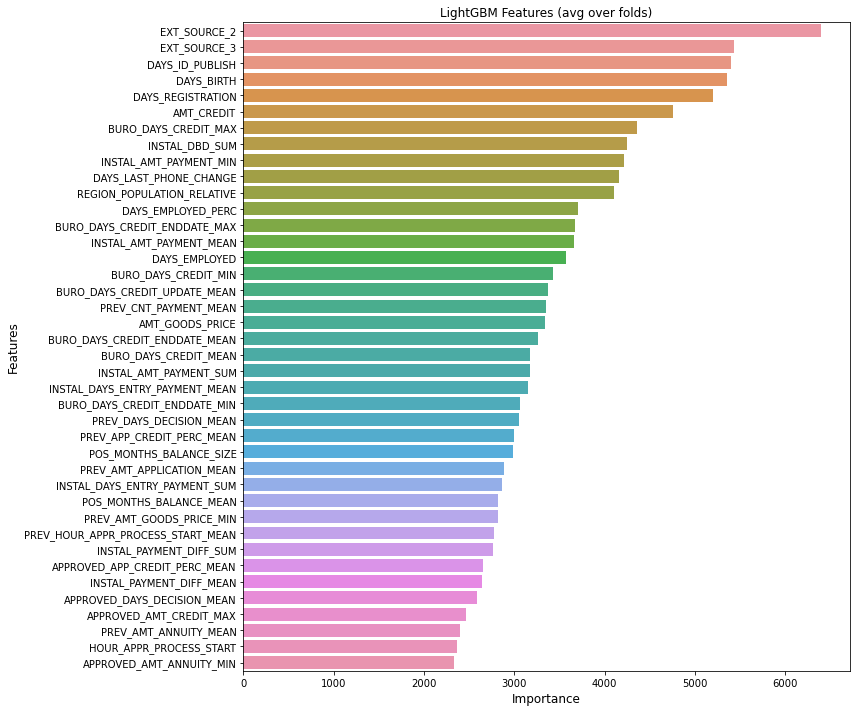

In [376]:
# Feature importance
feature_importance_df_ = pd.DataFrame({"importance":clf_lgbm_os["LightGBM"].feature_importances_, "feature":X_k_best_features.columns})

cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
plt.figure(figsize=(12, 10))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
plt.xlabel("Importance", fontsize=12);
plt.ylabel("Features", fontsize=12);
plt.title("LightGBM Features (avg over folds)")
plt.tight_layout()
plt.show()

<div class="alert alert-block alert-success">
    <p><b>Observations / Conclusions</b></p>
    <p>Within the most important features, we can see: </p>
    <ul style="list-style-type: square;">
        <li>EXT_SOURCE_2 and EXT_SOURCE_3: Data that comes from other financial institutions</li>
        <li>DAYS_BIRTH, DAYS_REGISTRATION: Age and antiquity of the person in the bank</li>
        <li>AMT_CREDIT: Previous credits application in the bank</li>
        <li>_MAX, _SUM, _MEAN, _PERC, _MIN: Characteristics from the feature engineering</li>
    </ul>    
</div>

<div style="background-color: #506AB9;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">11.1. Local interpretation</h3>
</div>

<div class="alert alert-block alert-info">
    <p>To make the local interpretation, we are going to use SHAP</p>
    <p>But first, we need to have our reduced dataset based on the Feature selection done</p>
</div>

In [377]:
cols = fs.get_support(indices=True)

In [378]:
df_X_test_fs = pd.DataFrame(
    data=X_test_fs, columns=X.iloc[:, cols].columns
)
df_X_test_fs.shape

(61502, 150)

In [379]:
df_X_test_fs_os, y_resampled = clf_lgbm_os["Smote"].fit_resample(df_X_test_fs, y_test)

In [380]:
clf_lgbm_os_explainer = shap.TreeExplainer(clf_lgbm_os["LightGBM"])

In [381]:
clf_lgbm_os_shap_values = clf_lgbm_os_explainer.shap_values(df_X_test_fs_os)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


<div class="alert alert-block alert-info">
    <p>Now we are going to analyze the result and influence of some features over an observation</p>
    <p>In this case, we are going to take an observation who is in default</p>
</div>

In [383]:
y_pred[10]

1

In [384]:
shap.force_plot(clf_lgbm_os_explainer.expected_value[0], 
                clf_lgbm_os_shap_values[0][10, :], 
                df_X_test_fs.iloc[10, :])

<div class="alert alert-block alert-success">
    <p><b>Observations / Conclusions</b></p>
    <ul style="list-style-type: square;">
        <li>We can notice that EXT_SOURCE_2, EXT_SOURCE_3 and AMT_GOODS_PRICE have a strong influence in the result for this observation pushing the prediction to the right</li>
    </ul> 
</div>

<div class="alert alert-block alert-info">
    <p>Let's analyze an observation is not in default</p>
</div>

In [385]:
y_pred[0]

0

In [386]:
shap.force_plot(clf_lgbm_os_explainer.expected_value[0], 
                clf_lgbm_os_shap_values[0][0, :], 
                df_X_test_fs.iloc[0, :])

<div class="alert alert-block alert-success">
    <p><b>Observations / Conclusions</b></p>
    <ul style="list-style-type: square;">
        <li>In this case, EXT_SOURCE_2 pushs the prediction to the left</li>
    </ul> 
</div>

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">12. Final re-training</h2>
</div>

<div class="alert alert-block alert-info">
    <p>We are going to apply our Feature Selection on the whole dataset excluding target variable</p>
</div>

In [387]:
X_fs = fs.transform(X)

<div class="alert alert-block alert-info">
    <p>Let's take advantages and save the features selected as dataset</p>
</div>

In [388]:
cols = fs.get_support(indices=True)

In [389]:
df_X = X.iloc[:, cols]

In [390]:
df_X.shape

(307507, 150)

In [391]:
data_key_feature_selected = "df_current_clients_feature_selected.csv"

In [392]:
data_location_feature_selected = "s3://{}/{}/{}".format(bucket, subfolder, data_key_feature_selected)

In [393]:
df_X.to_csv(data_location_feature_selected, index=False)

<div class="alert alert-block alert-info">
    <p>Now, Let's do the same for the clients to predict. In this way, we are going to save time at the time of execution</p>
</div>

In [394]:
df_clients_to_predict = df_clients_to_predict[TRAINING_COLUMNS]

In [395]:
df_clients_to_predict_fs = fs.transform(df_clients_to_predict)

In [396]:
cols = fs.get_support(indices=True)

In [397]:
df_clients_to_predict_fs = df_clients_to_predict.iloc[:, cols]

In [398]:
df_clients_to_predict_fs.shape

(48744, 150)

In [399]:
data_key_client_to_predict_feature_selected = "df_clients_to_predict_feature_selected.csv"

In [400]:
data_location_client_to_predict_feature_selected = "s3://{}/{}/{}".format(bucket, subfolder, data_key_client_to_predict_feature_selected)

In [401]:
df_clients_to_predict_fs.to_csv(data_location_client_to_predict_feature_selected, index=False)

<div class="alert alert-block alert-info">
    <p>Now, we can make the modelisation based on the current clients</p>
</div>

In [402]:
clf_lgbm_os.fit(X_fs, y_target)

Pipeline(steps=[('Smote', SMOTE(n_jobs=-1, random_state=42)),
                ['LightGBM',
                 LGBMClassifier(colsample_bytree=0.9497036, learning_rate=0.02,
                                max_depth=9, min_child_weight=39.3259775,
                                min_split_gain=0.0222415, n_estimators=8000,
                                num_leaves=32, random_state=42,
                                reg_alpha=0.041545473, reg_lambda=0.0735294,
                                subsample=0.8715623)]])

In [403]:
joblib.dump(clf_lgbm_os, "models/model_{version}.pkl".format(version=20220220))

['models/model_20220220.pkl']